In [118]:
from ai.semrep.datasets.deeplesion import DeepLesion                            
from ai.semrep.datasets.synthetic import Synthetic                              
from ai.semrep.utils.evaluation import (get_gradcam, 
                                        get_attention, 
                                        average_predictions, 
                                        get_bin_weakloc_scores,
                                        binarize_loc)
from copy import copy                                                           
from glob import glob                                                           
from scipy.cluster.hierarchy import leaves_list, linkage                        
from skimage import io                                                          
from skimage.morphology import binary_erosion, binary_dilation                  
from skimage.transform import resize                                            
from textwrap import wrap                                                       
import argparse                                                                 
import matplotlib.pyplot as plt                                                 
import numpy as np                                                              
import os                                                                       
import pandas as pd                                                             
import pickle                                                                   
import random                                                                   
import scipy.cluster.hierarchy as hc                                            
import scipy.spatial as sp                                                      
import seaborn as sns                                                           
import skimage.draw                                                             
import sys                                                                      
import torch                                                                    

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [119]:
# GLOBALS
BASEDIR = '/data/fast/TransientData/joseph.viviano/deep_lesion'
MODELTYPE = 'best'
IMGS = os.path.join(BASEDIR, 'Images_png')
METADATA = os.path.join(BASEDIR, 'DL_info.csv')
SEMANTICS = os.path.join(BASEDIR, 'text_mined_labels_171_and_split.json')
ONTOLOGY = os.path.join(BASEDIR, 'lesion_ontology_181022.xlsx')
THRESHS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

In [120]:
def convert_dtype(dictionary):
    """
    Converts all entries in all subdictionaries to be of datatype
    [int, float, str]. All non-matching entries are converted to str.
    """
    TYPES = [float, int, str, np.float32, np.float64, bool]
    
    for d in dictionary:
        if type(d) == dict:
            d = convert_dtype(d)
        else:
            if type(dictionary[d]) not in TYPES:
                dictionary[d] = str(dictionary[d])

def get_metrics(path, best=False):
    """
    Loads the outputs of training, if best, only 
    keeps best epoch for each dataframe.
    """
    all_df = [] 
    for f in glob(os.path.join(path, "*/stats_*.pkl")):
        d = pickle.load(open(f,"rb"))
        convert_dtype(d)
        d = pd.DataFrame.from_dict(d)
        
        if best:
            best_epoch = d.iloc[-1]['best_epoch']
            d = d[d['this_epoch'] == best_epoch]
        
        all_df.append(d)

    return(all_df)


def df_cleaner(df, verbose=True):
    """Selects the columns of the metrics dataframe to keep."""
    KEEP = ["auc", "best", "train_", "valid_", "test_", "loss", 
            "seed", "model", "epoch", "name", "optimizer"]
    for col in df.columns:
        if not any([string in col for string in KEEP]):
            del df[col]

    # Experiment name is determined by the configuration file used.
    experiments = df.experiment_name.unique()
    
    if verbose:
        print("resulting df \nshape={} tracking {} experiments, \nexperiments={}".format(
            df.shape, len(experiments), df.experiment_name.unique()))

    return df


def get_results_at_epoch(df, epoch, groups, cols, count=False, mode='mean'):
    """
    Shows a reduced form of the table with mean and std values 
    over experiments.
    """
    df_tmp = df[(df.this_epoch==epoch)].groupby(groups)[cols]
    if mode == 'mean':
        df = df_tmp.mean().join(df_tmp.std(),rsuffix='_std')
    elif mode == 'max':
        df = df_tmp.max().join(df_tmp.std(),rsuffix='_std')
    if count:
        df = df.join(df_tmp.count(), rsuffix='_count')
                                                                        
    return df


def get_best_results_at_epoch(df, epoch, count=False):
    """Get the test results at the best epoch."""
    groups = ['experiment_name']
    cols = ['best_valid_score', 'best_test_score',
            'model_SemanticRepresenter_Z_layers', 
            'model_SemanticRepresenter_l1_lamb',
            'model_SemanticRepresenter_mi_layers',
            'model_SemanticRepresenter_mi_sz_lamb',
            'model_SemanticRepresenter_mi_xz_lamb',
            'model_SemanticRepresenter_prior_lamb',
            'model_SemanticRepresenter_prior_layers']
    
    return get_results_at_epoch(df, epoch, groups, cols, count=count, mode='mean')


def load_model(model_name, model_type='best'):
    state_dict = os.path.join(BASE_DIR, "{}/{}_model_1234.pth.tar".format(
        model_name, model_type))
    mdl = torch.load(state_dict, map_location="cpu")
    mdl.device = "cpu"
    mdl.eval()
    
    return mdl


def compare_weakloc_methods(idx, inputs, X, S, y, seg, experiment='unnamed'):
    """Demonstrates the attention (multilevel) and gradcam (combined) for each model."""
    # 5 attention locations + 1 gradam + 1 filtered feature map + 1 raw feature map.
    WIDTH = 8  
    EPS = 10e-3
    LOCS = [0, 1, 2, 3, 4]  # Feature maps included in gradcam and raw visualization.
    n_plots = len(inputs) + 1  # Add one for the stimulus image.
    true_y = y[idx]
    
    # Plot non-attended and attended plots side-by-side.
    fig, axs = plt.subplots(n_plots+1, WIDTH, figsize=(24, 4*n_plots))
    axs = axs.ravel()
    
    # Plot input image.
    img = X.clone()  # If we don't do this, we manipulate X in the following lines.
    batch, chan, dim_x, dim_y = img.shape

    if chan > 1:
        chan_idx = chan//2
    else:
        chan_idx = 0

    img = img[idx, chan_idx, :, :].numpy()
    img -= np.mean(img)
    img /= np.std(img)
    
    box = seg[idx, :].numpy()
    if len(box.shape) == 4:
        box = box[0, 0, :, :]
    elif len(box.shape) == 3:
        box = box[0, :, :]
    box_ero = binary_dilation(binary_dilation(box))
    
    axs[0].imshow(img + 2.5*(box_ero-box), cmap='bone')  
    axs[0].set_title('y={}'.format(y[idx]))
    
    for i, input_model in enumerate(inputs):
        
        ROWIDX = (i+1)*WIDTH
        
        mdl = load_model(input_model)

        # Get the predicted value for this instance.
        outputs = mdl(X, S)
        y_hat = average_predictions(outputs)
        y_hat = y_hat.argmax(dim=1)
        y_hat = y_hat[idx]
    
        # Gradcam plot.
        all_gradcams = []

        for loc in LOCS:
            gradcam = get_gradcam(mdl, X, S, loc=loc)
            all_gradcams.append(gradcam[idx, :, :])

        gradcam = np.mean(np.stack(all_gradcams, axis=2), axis=2)
        vrange = np.max([np.abs(np.min(gradcam)), np.abs(np.max(gradcam))])
        axs[ROWIDX].imshow(img, cmap='bone')
        axs[ROWIDX].imshow(gradcam, cmap='RdBu_r', alpha=0.5, vmin=-vrange, vmax=vrange)
        axs[ROWIDX].set_title('{}:\n y_hat={}, range=+/-{:.2f}'.format(
            input_model, y_hat, vrange))
    
        # Attention Plots.
        attention, fm, y_hats, weight = get_attention(mdl, X, S)
        if len(attention) > 0:
            attention = np.stack(attention, axis=0)
            attention = attention[:, idx, :, :]
            fm = np.stack(fm, axis=0)
            fm = fm[:, idx, :, :]
            fm = np.mean(fm, axis=0)
            y_hats = np.stack(y_hats, axis=0)
            y_hats = y_hats[:, idx]
        else:
            attention = [np.zeros(gradcam.shape)]*5
            fm = np.zeros(gradcam.shape)
            y_hats = np.zeros(5)  # TODO: this is ugly.

        # Add the individual attention maps.
        for j in range(5):
            if j not in mdl.attn:
                axs[ROWIDX+WIDTH-1].set_visible(False)
            else:
                a = np.where(mdl.attn == j)[0][0]
                attn = attention[a, :, :]

                if y_hats[a] != true_y.numpy():
                    attn *= -1

                vrange = np.max([np.abs(np.min(attn)), np.abs(np.max(attn))])
                axs[ROWIDX+1+j].imshow(img, cmap='bone')
                axs[ROWIDX+1+j].imshow(attn, cmap='RdBu_r', alpha=0.5, vmin=-vrange, vmax=vrange)
                axs[ROWIDX+1+j].set_title('attn {}, y={}, range=+/-{:.2f}'.format(j, y_hats[a], vrange))
                
        # Add the filtered feautre map.
        if np.sum(np.abs(attention)) > 0:
            attention = np.sum(attention, axis=0)
            vrange = np.max([np.abs(np.min(attention)), np.abs(np.max(attention))])
            axs[ROWIDX+WIDTH-2].imshow(img * attention, cmap='bone')
            #axs[ROWIDX+WIDTH-2].imshow(attention, cmap='RdBu_r', alpha=0.5, vmin=-vrange, vmax=vrange)
            axs[ROWIDX+WIDTH-2].set_title('filtered feature map, range=+/-{:.2f}'.format(vrange))
        else:
            axs[ROWIDX+WIDTH-2].set_visible(False)
                        
        # Add the mean feature map.
        if np.sum(np.abs(fm)) > 0:
            vrange = np.max([np.abs(np.min(fm)), np.abs(np.max(fm))])
            axs[ROWIDX+WIDTH-1].imshow(img * fm, cmap='bone')
            #axs[ROWIDX+WIDTH-1].imshow(fm, cmap='RdBu_r', alpha=0.5, vmin=-vrange, vmax=vrange)
            axs[ROWIDX+WIDTH-1].set_title('feature map, range=+/-{:.2f}'.format(vrange))
        else:
            axs[ROWIDX+WIDTH-1].set_visible(False)
        
        # Turn off x + y labels.
        for i in range(len(axs)):
            axs[i].set_axis_off()
    
    fig.suptitle('{} Weak Localization'.format(experiment))
    fig.set_tight_layout(True)
    fig.show();

    
def plot_performance(df, experiment):
    """
    Plots valid AUC vs a weakloc measure for all runs in an experiment.
    """
    _df = df[df.experiment_name.str.contains(experiment)]
    
    fig, axs = plt.subplots(2, 2, sharex=True, figsize=(10, 8))
    ys = ["valid_clf_A", "valid_clf_Z", 
          "valid_l1_A", "valid_l1_z"]
    
    for i, ax in enumerate(axs.ravel()):
        legend = 'brief' if i == 1 else False
        sns.scatterplot(x="valid_auc", y=ys[i], hue="experiment_name", 
                        data=_df, ax=ax, legend=legend)
        ax.set_title("{}: {}".format(experiment, ys[i]))

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    fig.tight_layout()

    plt.show()

    
def plot_loss_performance(df, experiment):
    _df = df[df.experiment_name.str.contains(experiment)]

    fig, axs = plt.subplots(2, 4, sharex=True, figsize=(20, 6.66))
    ys = ["train_clf_Z", "train_clf_A", "train_l1_z", "train_l1_A",
          "valid_clf_Z", "valid_clf_A", "valid_l1_z", "valid_l1_A"]

    for i, ax in enumerate(axs.ravel()):
        legend = 'brief' if i == 3 else False
        sns.lineplot(x="this_epoch", y=ys[i], hue="experiment_name", 
                     data=_df, ax=ax, legend=legend)
        ax.set(ylim=(-0.05, 1.05))
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    fig.tight_layout()
    plt.show()

    
def get_inputs(df, dataloader, experiment):
    iterator = iter(dataloader)
    X, S, y, seg = next(iterator)
    inputs = list(df.experiment_name.unique())
    inputs = list(filter(lambda x: experiment in x, inputs))
    inputs.sort()
    
    idx = np.random.choice(range(len(y)))
    
    return (idx, inputs, X, S, y, seg)


def plot_weights(inputs, X, S, y):
    """Plots the attention weights over a batch."""
    for input_model in inputs:
        mdl = load_model(input_model)
        attention, fm, y_hats, weight = get_attention(mdl, X, S)

        fig, axs = plt.subplots(len(weight), 1, figsize=(10, 4*len(weight)))

        if len(weight) > 1:
            axs = axs.ravel()
        else:
            axs = [axs]
        
        for i, w in enumerate(weight):
            
            # Colour incorrect predictions blue.
            correct = y_hats[i].numpy() == y.numpy()
            vrange = np.max(w)
            w[~correct, :] *= -1
                        
            # Reorder along batch dimension to see clusters 
            # in attention application.
            idx = leaves_list(linkage(w, method='ward'))
            w = w[idx, :]

            axs[i].imshow(w, cmap='RdBu_r', aspect='auto', vmin=-vrange, vmax=vrange)
            axs[i].set_yticks(range(len(y)))
            axs[i].set_yticklabels(y_hats[i].numpy()[idx])  # Reordered to match w.
            axs[i].set_ylabel('Class')
            if i+1 == len(weight):
                axs[i].set_xlabel('Feature Map Channel')

        plt.tight_layout()
        plt.show();

        
def get_weakloc_stats(mdl, dataloader):
    """IOP, IOT, IOU over thresholds."""

    all_gradcams = []
    all_attentions = []
    all_boxes = []
    all_ys = []
    
    LOCS = [0, 1, 2, 3, 4]
    
    # Get all localizations from the dataloader.
    for X, S, y, box in dataloader:
        
        X = torch.FloatTensor(X)
        S = S.float()

        batch_gradcams = []
        for loc in LOCS:
            gradcam = get_gradcam(mdl, X, S, loc=loc)
            batch_gradcams.append(gradcam)

        # Mean across all locs.
        gradcam = np.mean(np.stack(batch_gradcams, axis=3), axis=3)
        attention, fm, y_hats, weight = get_attention(mdl, X, S)
        all_gradcams.append(gradcam)
        if len(attention) > 0:
            all_attentions.append(np.mean(np.stack(attention, axis=3), axis=3))
        all_boxes.append(box)
        all_ys.append(y)

    # Giant batches.
    gradcam = np.concatenate(all_gradcams, axis=0)
    if len(attention) > 0:
        attention = np.concatenate(all_attentions, axis=0)
    box = np.concatenate(all_boxes, axis=0)
    y = np.concatenate(all_ys, axis=0)

    # Conversion for weakloc metrics.
    if len(box.shape) == 4:
        box = box[:, 0, :, :]  # Remove singleton dimension.
    box = box.astype(bool)
    
    # Only look at the positive (sick) class.
    gradcam = gradcam[y==1, :, :]
    if len(attention) > 0:
        attention = attention[y==1, :, :]
    box = box[y==1, :, :]
    
    # Returns lists of these scores over thresholds.
    ious_grad, iops_grad, iots_grad = [], [], []
    ious_attn, iops_attn, iots_attn = [], [], []

    for thresh in THRESHS:
        iou_grad, iop_grad, iot_grad = get_bin_weakloc_scores(
            binarize_loc(gradcam, box, pct_kept=thresh), box)
        ious_grad.append(iou_grad)
        iops_grad.append(iop_grad)
        iots_grad.append(iot_grad)
  
        if len(attention) > 0:
            iou_attn, iop_attn, iot_attn = get_bin_weakloc_scores(
                binarize_loc(attention, box, pct_kept=thresh), box)
            ious_attn.append(iou_attn)
            iops_attn.append(iop_attn)
            iots_attn.append(iot_attn)
    
    return (ious_grad, iops_grad, iots_grad,
            ious_attn, iops_attn, iots_attn)


def get_weakloc_table(inputs, dataloader):

    table = []  # Will become our dataframe.
    for i in inputs:
        state_dict = os.path.join(BASE_DIR, "{}/{}_model_1234.pth.tar".format(i, MODELTYPE))
        mdl = torch.load(state_dict, map_location="cpu")
        mdl.device = "cpu"
        
        results = get_weakloc_stats(mdl, dataloader)
        ious_grad, iops_grad, iots_grad, ious_attn, iops_attn, iots_attn = results 
        
        for j, thresh in enumerate(THRESHS):
            # experiment_name, loc_type, threshold, score_name, score. 
            table.append([i, 'GradCam', thresh, 'iou', ious_grad[j]])
            table.append([i, 'GradCam', thresh, 'iop', iops_grad[j]])
            table.append([i, 'GradCam', thresh, 'iot', iots_grad[j]])
            
            if len(ious_attn) > 0:
                table.append([i, 'Attention', thresh, 'iou', ious_attn[j]])
                table.append([i, 'Attention', thresh, 'iop', iops_attn[j]])
                table.append([i, 'Attention', thresh, 'iot', iots_attn[j]])

        del mdl
    
    df = pd.DataFrame(table, columns=['Experiment', 'Loc Type', 
                                      'Threshold', 'Score', 'Value'])

    return df

Collects all Stats Available in results/
------------------------------------------------------

In [121]:
# Collects all of the results available
all_df = get_metrics("../../../results/")
all_best_df = get_metrics("../../../results/", best=True)

df_best = pd.concat(all_best_df, ignore_index=True)
df = pd.concat(all_df, ignore_index=True)
df = df_cleaner(df)
df_best = df_cleaner(df_best, verbose=False)

resulting df 
shape=(4360, 159) tracking 46 experiments, 
experiments=['synthetic_weakloc_visual_l1_fa_noZ'
 'deeplesion_weakloc_visual_l1_fa_noZ' 'deeplesion_clf_visual+mixup'
 'deeplesion_weakloc_multimodal_film_noZ' 'synthetic_weakloc_visual'
 'deeplesion_weakloc_visual_fa' 'deeplesion_clf_visual'
 'synthetic_weakloc_visual_l1' 'synthetic_weakloc_visual_l1_fa'
 'deeplesion_weakloc_visual_l1_film_noZ'
 'deeplesion_weakloc_visual_film_noZ'
 'synthetic_weakloc_multimodal_l1_film_noZ'
 'synthetic_weakloc_multimodal_l1_fa' 'deeplesion_clf_visual+prior'
 'synthetic_weakloc_visual_fa_noZ'
 'synthetic_weakloc_multimodal_l1_fa_noZ' 'deeplesion_clf_semrep'
 'deeplesion_clf_visual+dim+prior' 'deeplesion_weakloc_multimodal_fa_noZ'
 'synthetic_weakloc_multimodal_l1' 'synthetic_weakloc_visual_fa'
 'synthetic_weakloc_visual_film_noZ' 'synthetic_weakloc_multimodal'
 'deeplesion_weakloc_multimodal_l1_film_noZ' 'deeplesion_clf_semrep+prior'
 'deeplesion_weakloc_multimodal' 'deeplesion_weakloc_multimo

Weakloc Performance
--------------------------------

No handles with labels found to put in legend.


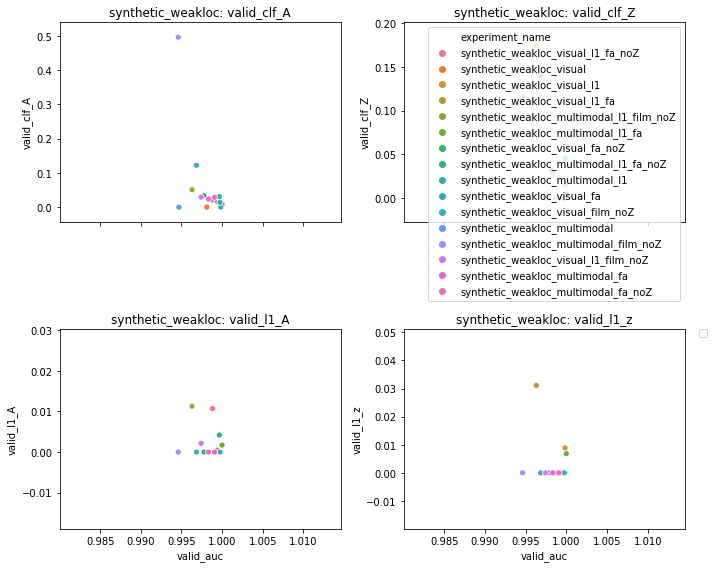

No handles with labels found to put in legend.


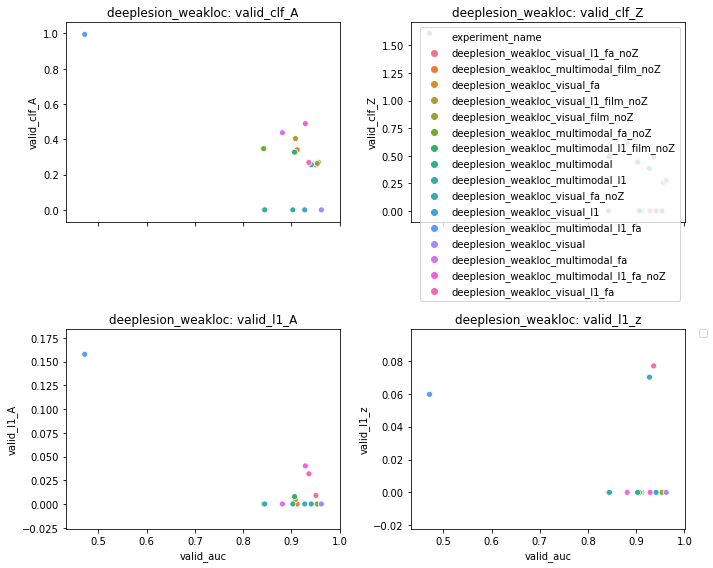

In [108]:
plot_performance(df_best, experiment='synthetic_weakloc');
plot_performance(df_best, experiment='deeplesion_weakloc');   

Loss Monitoring
------------------------

No handles with labels found to put in legend.


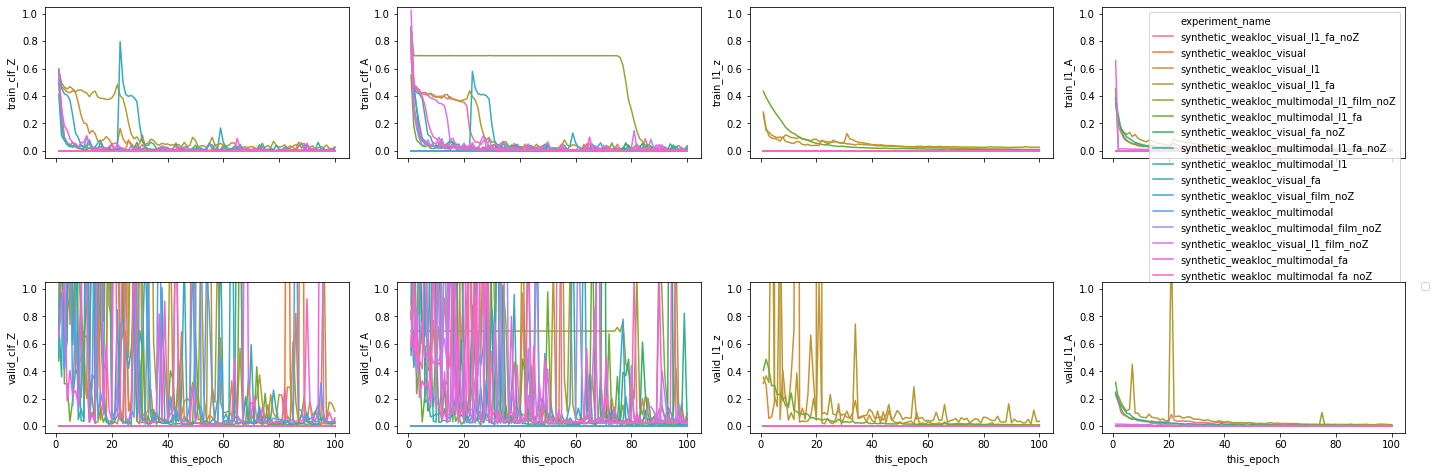

In [109]:
plot_loss_performance(df, experiment='synthetic_weakloc')

Best Epoch AUC and Weakloc Scores (Early Stopping)
----------------------------------------------------------------------------

In [116]:
def get_best_results(df, experiment, cols):
    _df = df[df.experiment_name.str.contains(experiment)]
    #for c in _df.columns:
    #    print(c)
    return _df.groupby(['experiment_name']).mean()[cols]

os.makedirs('tables/', exist_ok=True)

with open('tables/weakloc_synthetic.tex','w') as tf:
    tf.write(get_best_results(df_best, 'synthetic_weakloc', 
                              ['best_test_loss', 'best_test_score', 'best_epoch']).to_latex())

with open('tables/weakloc_deeplesion.tex','w') as tf:
    tf.write(get_best_results(df_best, 'deeplesion_weakloc', 
                              ['best_test_loss', 'best_test_score', 'best_epoch']).to_latex())

with open('tables/clf_deeplesion.tex','w') as tf:
    tf.write(get_best_results(df_best, 'deeplesion_clf', 
                              ['best_train_loss', 'best_valid_loss', 'best_test_loss', 'best_valid_score', 'best_test_score', 'best_epoch']).to_latex())

In [122]:
get_best_results(df_best, 'deeplesion_clf', 
                              ['best_train_loss', 'best_valid_loss', 'best_test_loss', 'best_valid_score', 'best_test_score', 'best_epoch'])

,best_train_loss,best_valid_loss,best_test_loss,best_valid_score,best_test_score,best_epoch
experiment_name,,,,,,
deeplesion_clf_multimodal,0.362937,0.494802,0.462743,0.975613,0.977054,2
deeplesion_clf_semrep,2.199927,3.203149,3.352561,0.938143,0.931979,26
deeplesion_clf_semrep+dim,2.187904,3.209140,3.242984,0.939723,0.938022,26
deeplesion_clf_semrep+dim+prior,1.261919,1.680279,1.645127,0.925451,0.923809,15
deeplesion_clf_semrep+dim+unlabeled,2.227100,2.708688,2.680608,0.950047,0.946091,15
deeplesion_clf_semrep+prior,0.940022,1.497729,1.456997,0.926489,0.929303,22
deeplesion_clf_semrep+unlabeled,2.181479,2.709733,2.643513,0.950632,0.948365,15
deeplesion_clf_semrep_mixup,0.989781,1.515761,1.513159,0.896991,0.904504,4
deeplesion_clf_visual,0.551286,0.870130,0.880824,0.924766,0.925477,7


In [58]:
get_best_results(df_best, 'deeplesion_weakloc', 
                              ['best_test_loss', 'best_test_score', 'best_epoch'])

,best_test_loss,best_test_score,best_epoch
experiment_name,,,
deeplesion_weakloc_multimodal,0.387250,0.887698,3
deeplesion_weakloc_multimodal_fa,0.735182,0.912161,19
deeplesion_weakloc_multimodal_fa_noZ,0.372238,0.856096,4
deeplesion_weakloc_multimodal_film_noZ,0.326762,0.873740,7
deeplesion_weakloc_multimodal_l1,0.431567,0.873576,7
deeplesion_weakloc_multimodal_l1_fa,1.178628,0.905795,15
deeplesion_weakloc_multimodal_l1_fa_noZ,0.347620,0.929832,21
deeplesion_weakloc_multimodal_l1_film_noZ,0.300010,0.919028,25
deeplesion_weakloc_visual,0.257598,0.957179,91


In [24]:
get_best_results(df_best, 'synthetic_weakloc', 
                              ['best_test_loss', 'best_test_score', 'best_epoch'])

,best_test_loss,best_test_score,best_epoch
experiment_name,,,
synthetic_weakloc_multimodal,0.001573,1.000000,57
synthetic_weakloc_multimodal_fa,0.026559,0.999974,13
synthetic_weakloc_multimodal_fa_noZ,0.008650,0.999920,57
synthetic_weakloc_multimodal_film_noZ,0.016540,0.998232,57
synthetic_weakloc_multimodal_l1,0.001952,1.000000,19
synthetic_weakloc_multimodal_l1_fa,0.014368,1.000000,95
synthetic_weakloc_multimodal_l1_fa_noZ,0.011007,0.999926,60
synthetic_weakloc_multimodal_l1_film_noZ,0.003713,1.000000,97
synthetic_weakloc_visual,0.011775,0.999940,21


Dataset Management: Small Batch
-------------------------------------------------

In [59]:
# Dataset visualization.
#data = DeepLesion('test', IMGS, METADATA, SEMANTICS, ONTOLOGY, 
#                  task='lesion', patch_size=200, patch_offset=0,
#                  to_keep='labelled')

BATCH_SIZE = 8
BASE_DIR = '/export/home/joseph.viviano/code/semrep/results'
synth_data = Synthetic('/export/home/joseph.viviano/code/semrep/data/synthetic_objects/test')
synth_load = torch.utils.data.DataLoader(synth_data, batch_size=BATCH_SIZE, shuffle=True)
deepl_data =  DeepLesion('test', IMGS, METADATA, SEMANTICS, ONTOLOGY, 
                         task='lesion', patch_size=100, patch_offset=0,
                         to_keep='labelled', num_slices=3)
deepl_load = torch.utils.data.DataLoader(deepl_data, batch_size=BATCH_SIZE, shuffle=True)

Synthetic Dataloader: /export/home/joseph.viviano/code/semrep/data/synthetic_objects/test
DeepLesion Dataloader: test
n=1876, len(S)=171


Weakloc Visualization
-------------------------------

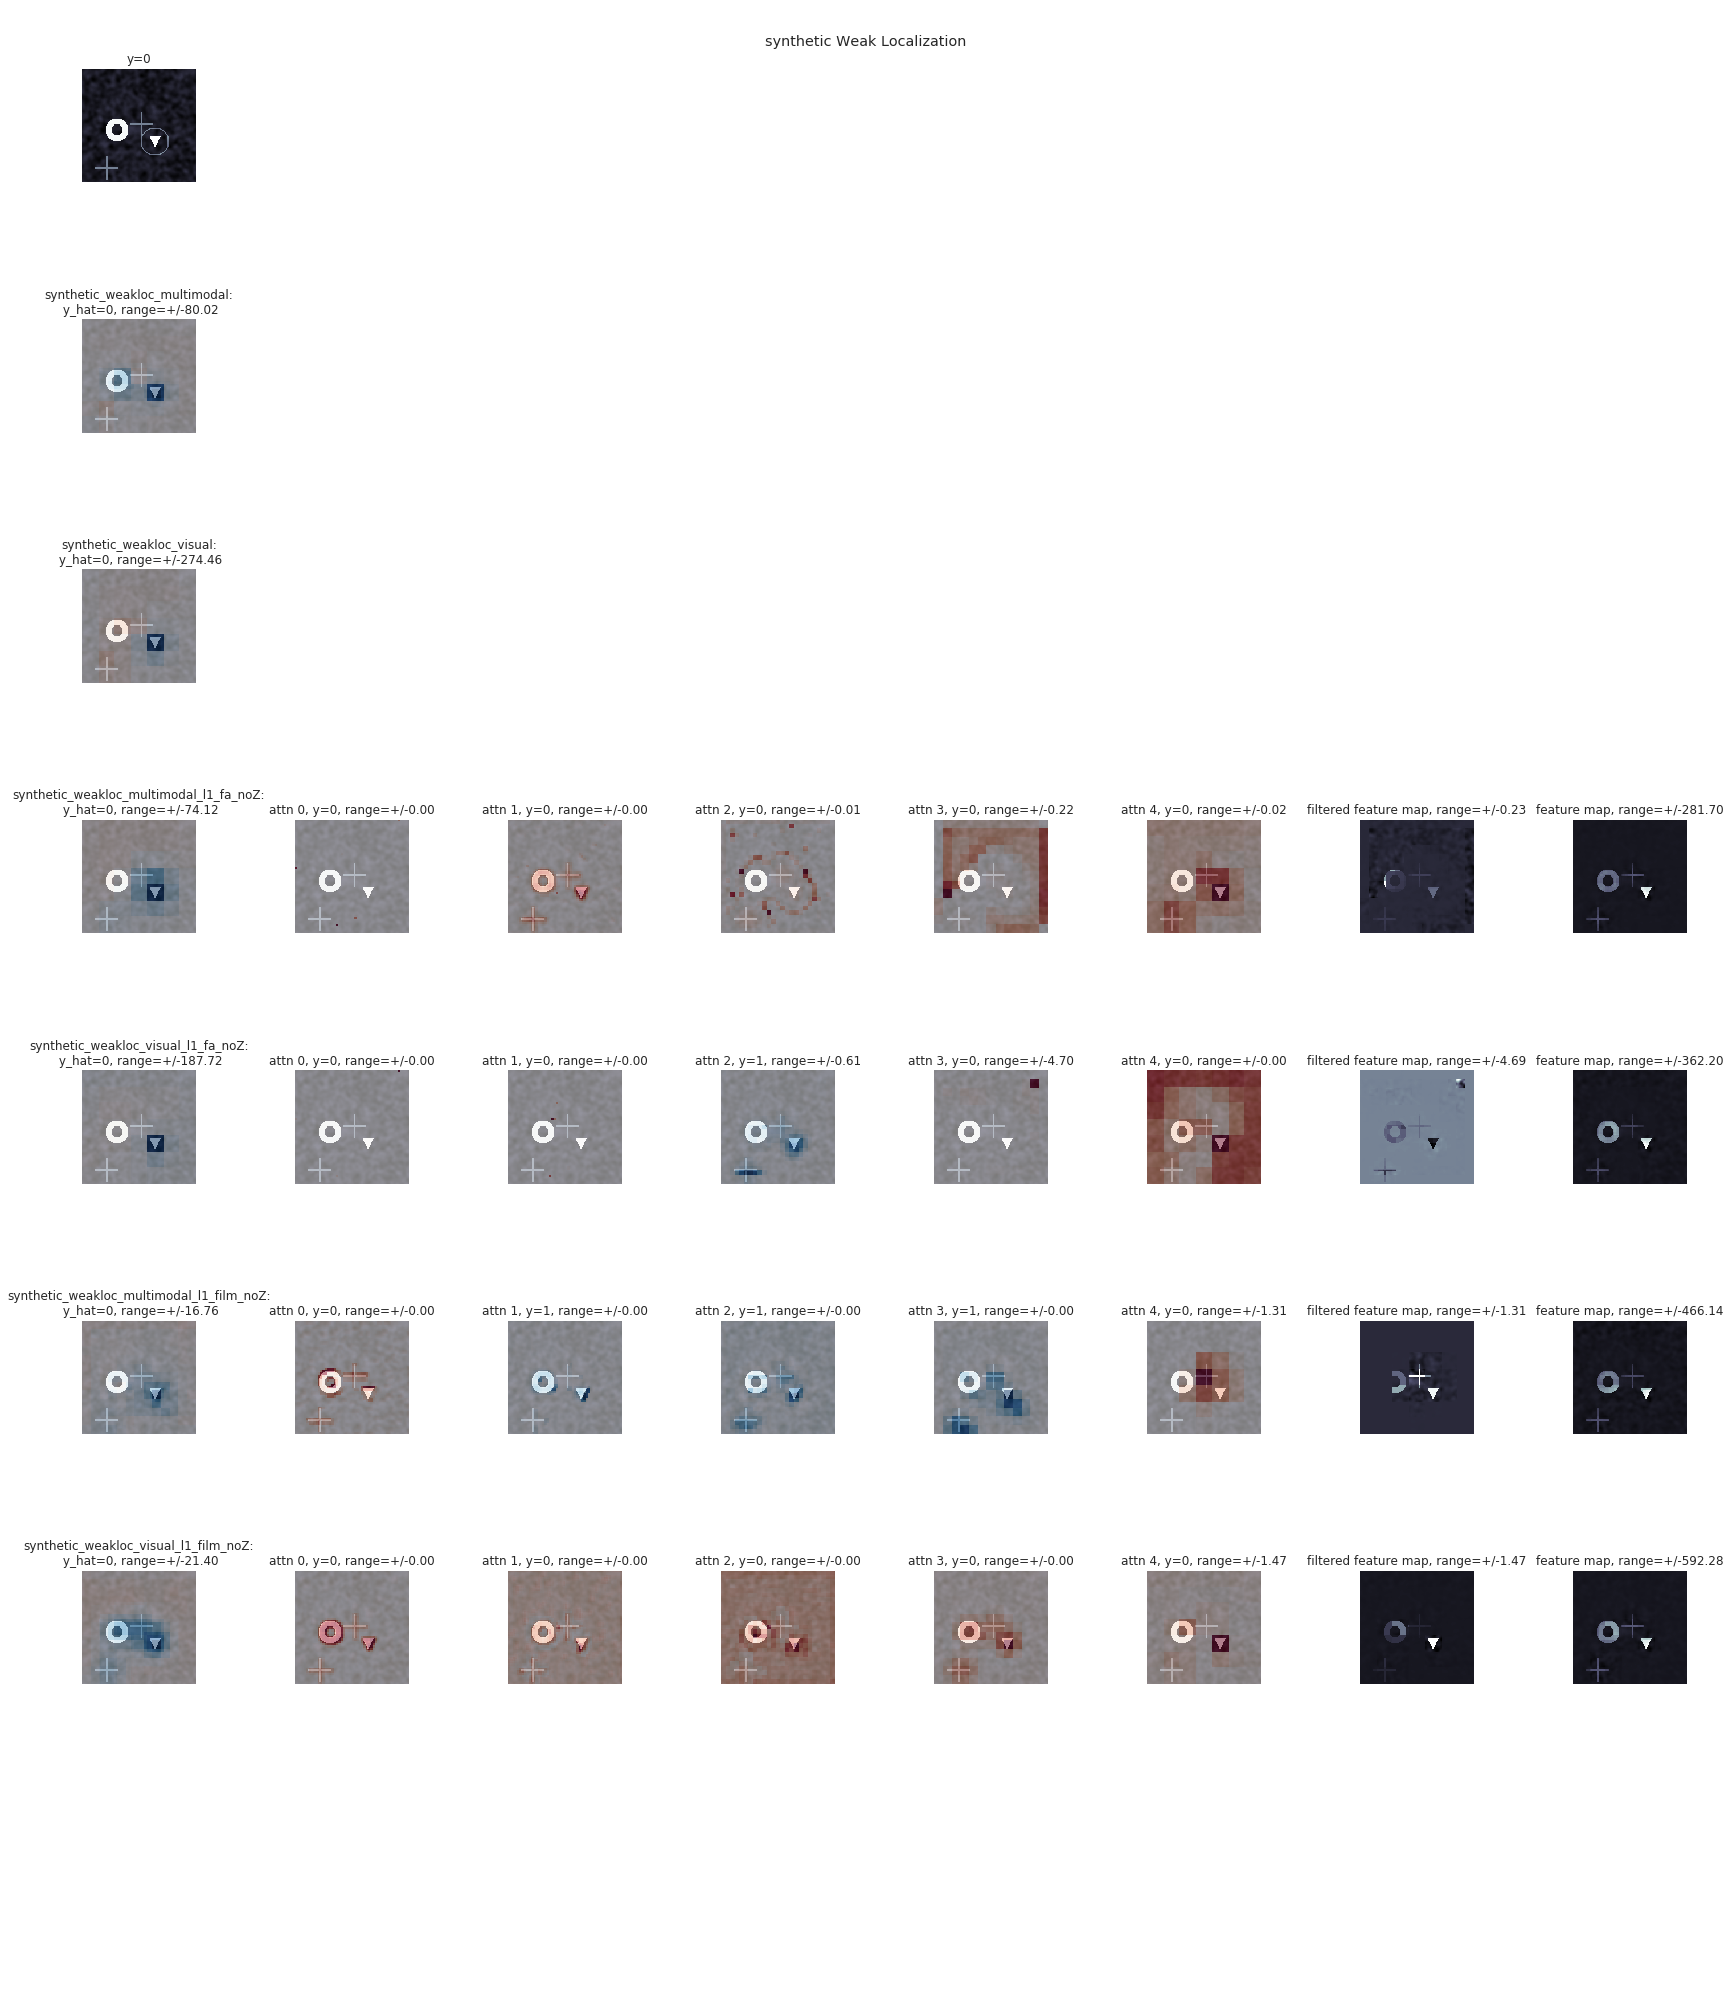

In [47]:
idx, inputs, X, S, y, seg = get_inputs(df, synth_load, 'synthetic')
INPUTS = ['synthetic_weakloc_multimodal',
          'synthetic_weakloc_visual',
          'synthetic_weakloc_multimodal_l1_fa_noZ',
          'synthetic_weakloc_visual_l1_fa_noZ',
          'synthetic_weakloc_multimodal_l1_film_noZ',
          'synthetic_weakloc_visual_l1_film_noZ']
compare_weakloc_methods(idx, INPUTS, X, S, y, seg, experiment='synthetic'); # bestsquares

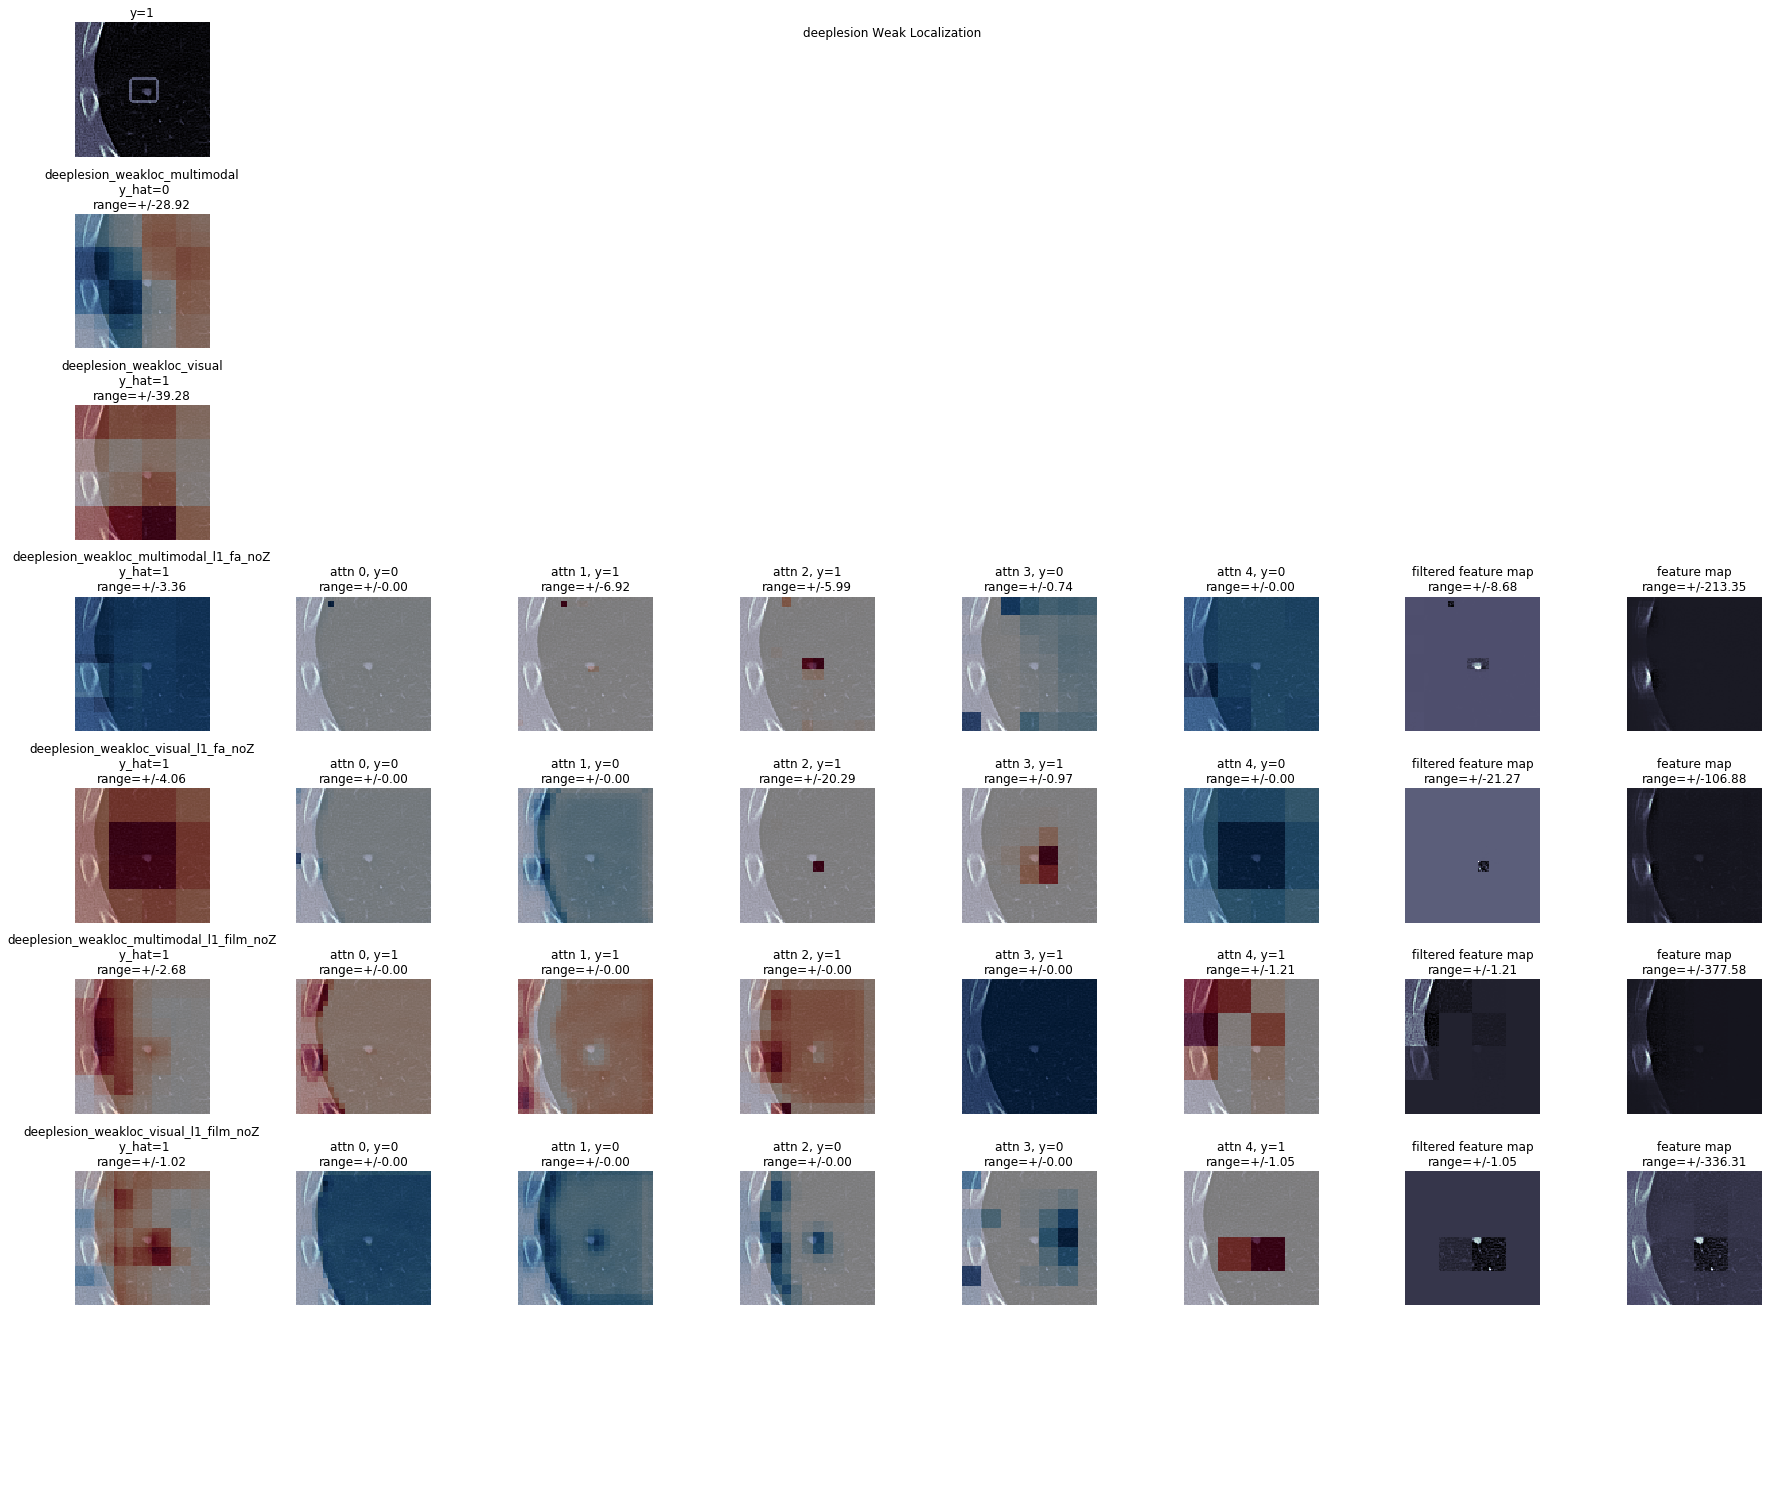

In [103]:
idx, inputs, X, S, y, seg = get_inputs(df, deepl_load, 'deeplesion_weakloc')
INPUTS = ['deeplesion_weakloc_multimodal',
          'deeplesion_weakloc_visual',
          'deeplesion_weakloc_multimodal_l1_fa_noZ',
          'deeplesion_weakloc_visual_l1_fa_noZ',
          'deeplesion_weakloc_multimodal_l1_film_noZ',
          'deeplesion_weakloc_visual_l1_film_noZ']
compare_weakloc_methods(idx, INPUTS, X, S, y, seg, experiment='deeplesion');

Dataset Management: Large Batch
--------------------------------------------------

In [8]:
BATCH_SIZE = 256
BASE_DIR = '/export/home/joseph.viviano/code/semrep/results'
synth_data = Synthetic('/export/home/joseph.viviano/code/semrep/data/synthetic_objects/test')
synth_load = torch.utils.data.DataLoader(synth_data, batch_size=BATCH_SIZE, shuffle=True)
deepl_data =  DeepLesion('test', IMGS, METADATA, SEMANTICS, ONTOLOGY, 
                         task='lesion', patch_size=100, patch_offset=0,
                         to_keep='labelled', num_slices=3)
deepl_load = torch.utils.data.DataLoader(deepl_data, batch_size=BATCH_SIZE, shuffle=True)


Synthetic Dataloader: /export/home/joseph.viviano/code/semrep/data/synthetic_objects/test
DeepLesion Dataloader: test
n=1876, len(S)=171


Weakloc Stats (LONG Runtime)
--------------------------------------------

In [9]:
_, inputs, _, _, _, _ = get_inputs(df, deepl_load, 'deeplesion_weakloc')
df_deepl = get_weakloc_table(inputs, deepl_load)
_, inputs, _, _, _, _ = get_inputs(df, synth_load, 'synthetic_weakloc')
df_synth = get_weakloc_table(inputs, synth_load)

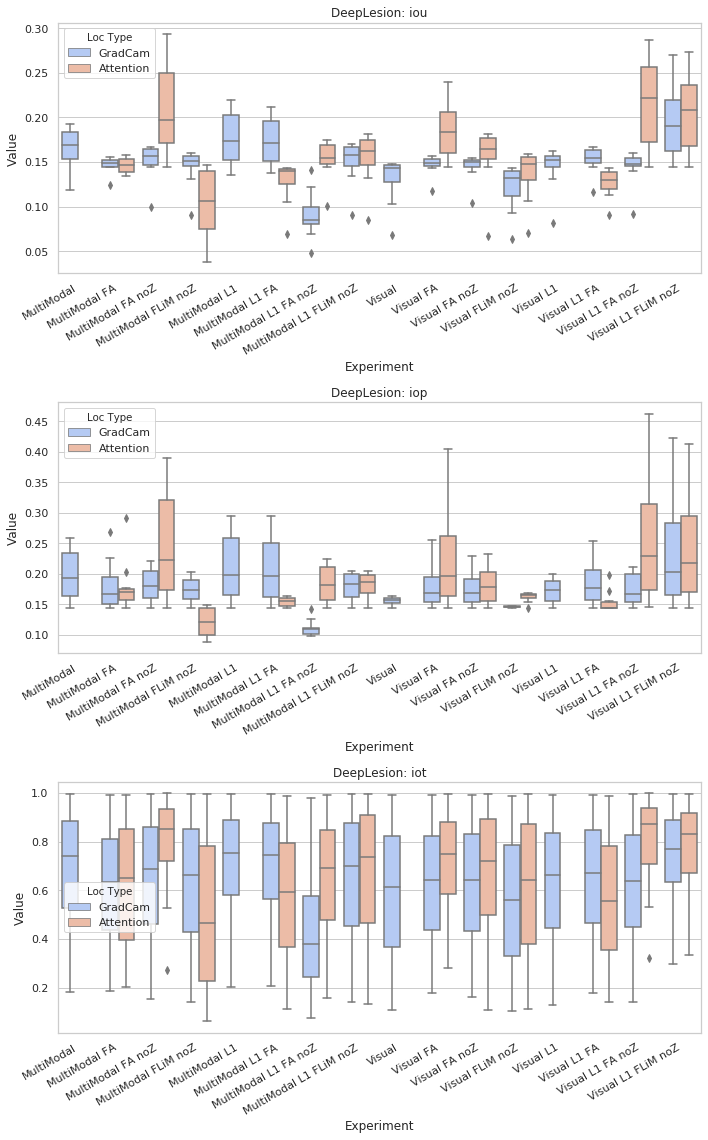

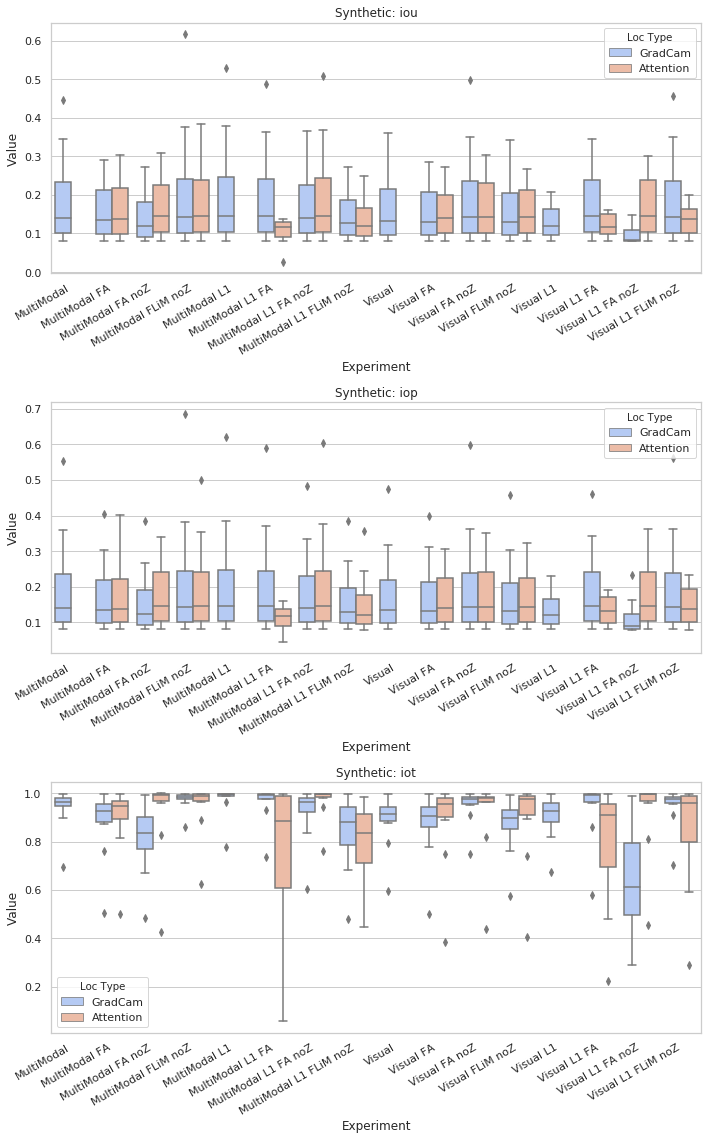

In [12]:
EXP_DICT = {'deeplesion_weakloc_multimodal': 'MultiModal',
            'deeplesion_weakloc_multimodal_fa': 'MultiModal FA',
            'deeplesion_weakloc_multimodal_fa_noZ': 'MultiModal FA noZ',
            'deeplesion_weakloc_multimodal_film_noZ': 'MultiModal FLiM noZ',
            'deeplesion_weakloc_multimodal_l1': "MultiModal L1",
            'deeplesion_weakloc_multimodal_l1_fa': 'MultiModal L1 FA',
            'deeplesion_weakloc_multimodal_l1_fa_noZ': 'MultiModal L1 FA noZ',
            'deeplesion_weakloc_multimodal_l1_film_noZ': 'MultiModal L1 FLiM noZ',
            'deeplesion_weakloc_visual': 'Visual',
            'deeplesion_weakloc_visual_fa': 'Visual FA',
            'deeplesion_weakloc_visual_fa_noZ': 'Visual FA noZ',
            'deeplesion_weakloc_visual_film_noZ': 'Visual FLiM noZ',
            'deeplesion_weakloc_visual_l1': 'Visual L1',
            'deeplesion_weakloc_visual_l1_fa': 'Visual L1 FA',
            'deeplesion_weakloc_visual_l1_fa_noZ': 'Visual L1 FA noZ',
            'deeplesion_weakloc_visual_l1_film_noZ': 'Visual L1 FLiM noZ',
            'synthetic_weakloc_multimodal': 'MultiModal',
            'synthetic_weakloc_multimodal_fa': 'MultiModal FA',
            'synthetic_weakloc_multimodal_fa_noZ': 'MultiModal FA noZ',
            'synthetic_weakloc_multimodal_film_noZ': 'MultiModal FLiM noZ',
            'synthetic_weakloc_multimodal_l1': 'MultiModal L1',
            'synthetic_weakloc_multimodal_l1_fa': 'MultiModal L1 FA', 
            'synthetic_weakloc_multimodal_l1_fa_noZ': 'MultiModal L1 FA noZ',
            'synthetic_weakloc_multimodal_l1_film_noZ': 'MultiModal L1 FLiM noZ',
            'synthetic_weakloc_visual': 'Visual',
            'synthetic_weakloc_visual_fa': 'Visual FA',
            'synthetic_weakloc_visual_fa_noZ': 'Visual FA noZ',
            'synthetic_weakloc_visual_film_noZ': 'Visual FLiM noZ',
            'synthetic_weakloc_visual_l1': 'Visual L1',
            'synthetic_weakloc_visual_l1_fa': 'Visual L1 FA',
            'synthetic_weakloc_visual_l1_fa_noZ': 'Visual L1 FA noZ',
            'synthetic_weakloc_visual_l1_film_noZ': 'Visual L1 FLiM noZ',
            'synthetic_weakloc_multimodal_fa': 'MultiModal FA'}

def plot_weakloc_stats(df_in, title):

    df = df_in.copy()
    df['Experiment'] = df['Experiment'].replace(EXP_DICT)
    
    fig, axs = plt.subplots(3, 1, sharex=False, figsize=(10, 16))
    ys = ['iou', 'iop', 'iot']
    sns.set(style="whitegrid")
    
    for i, ax in enumerate(axs.ravel()):
        #legend = 'brief' if i == 0 else False
        p = sns.boxplot(x="Experiment", y="Value", hue='Loc Type', 
                        data=df[df["Score"] == ys[i]], ax=ax,
                        palette='coolwarm')

        p.set_title("{}: {}".format(title, ys[i]))
        p.set_xticklabels(p.get_xticklabels(), rotation=30, ha='right')
    
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    fig.tight_layout()

plot_weakloc_stats(df_deepl, title='DeepLesion');
plot_weakloc_stats(df_synth, title='Synthetic');

In [44]:
# Deeplesion Synth IOT Results (because plot is so hard to read).
df_to_write = df_deepl[df_deepl['Score'] == 'iot'].groupby(['Experiment', 'Loc Type', 'Score']).mean()

with open('tables/weakloc_synthetic_iot.tex','w') as tf:
    tf.write(df_to_write.to_latex())

Text(0.5, 1, 'Score = IOP')

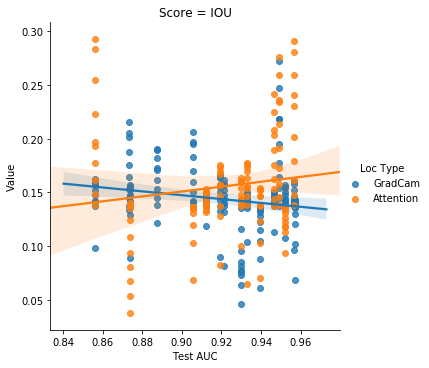

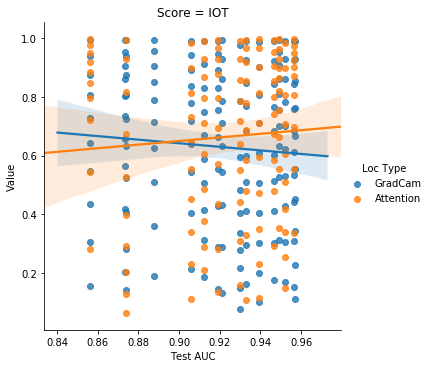

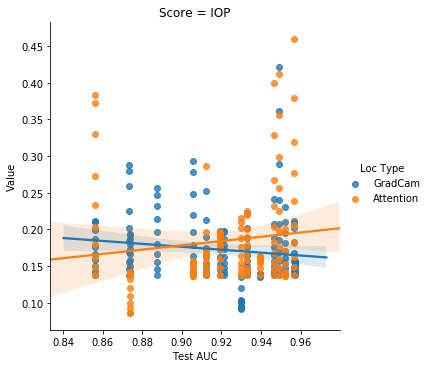

In [58]:
# Relationship b/t classification scores and weakloc scores
#
sc = get_best_results(df_best, 'deeplesion_weakloc', ['best_test_score'])

def add_scores(df_in, scores):
    df = df_in.copy()
    df['Test AUC'] = np.nan
    
    for experiment_name in scores.index:
        df.loc[df.Experiment == experiment_name, 'Test AUC'] = scores.loc[experiment_name, 'best_test_score']
        
    return df
        
df_deepl_sc = add_scores(df_deepl, sc)

sns.lmplot(x="Test AUC", y="Value", hue='Loc Type',
           data=df_deepl_sc.loc[df_deepl_sc.Score == 'iou']).ax.set_title('Score = IOU')
sns.lmplot(x="Test AUC", y="Value", hue='Loc Type',
           data=df_deepl_sc.loc[df_deepl_sc.Score == 'iot']).ax.set_title('Score = IOT')
sns.lmplot(x="Test AUC", y="Value", hue='Loc Type',
           data=df_deepl_sc.loc[df_deepl_sc.Score == 'iop']).ax.set_title('Score = IOP')

Attention Weights (Diagnostic) 
--------------------------------------------

In [ ]:
#plot_weights(inputs, X, S, y)

Evaluate Performance Across Entire Dataset
------------------------------------------------------------

In [ ]:
from ai.semrep.training import evaluate_epoch

for i in inputs:
    
    state_dict = os.path.join(BASE_DIR, "{}/{}_model_1234.pth.tar".format(i, MODELTYPE))
    mdl = torch.load(state_dict, map_location="cpu")
    mdl.device = "cpu"
    
    print(i)
    loss, score, _, metrics = evaluate_epoch(
        mdl, 'cpu', dataloader, 0, i, None, mode='weakloc', name='valid')